In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.linalg as la
import pickle
import os.path

import qiskit
from qiskit import Aer
from qiskit import IBMQ
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.circuit import Parameter
from qiskit.providers.aer import noise
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
import datetime
import networkx as nx
import itertools

# some definitions of gate unitaries
s0 = np.array([[1,0],[0,1]])
sx = np.array([[0,1],[1,0]])
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])
s = np.array([sx, sy, sz])
h = np.array([[1,1],[1,-1]])/np.sqrt(2)

# number of qubits in the quantum circuit
n_qubits = 5
state = ['|0>','|1>','|+>','|->','|y+>','|y->']

In [2]:
# some helpful functions

# get_bin converts an integer x to a binary number with (n_qubits-1) bits, i.e. get_bin(3) -> '011' 
get_bin = lambda x, n=(n_qubits-1): format(x, 'b').zfill(n)

def ret(dictionary, key):
    if key in dictionary:
        return dictionary[key]
    else:
        return 0
def next_file(filename, file_extension="pdf", folder="exp-data", replace_last=True):
    """
    Return another filename with increased index. If files '0_filename.pdf' and '1_filename.pdf' already exist, 
    and if replace_last=False, this function will return '2_filename.pdf'. In the case, where replace_last=True,
    it will return the last existing filename, i.e. '1_filename.pdf' in above example.
    """
    idxx = 0
    while(True):
        ff = f"{folder}/{idxx}_{filename}.{file_extension}"
        if not os.path.exists(ff):
            break
        idxx += 1
    if replace_last and idxx > 0:
        ff = f"{folder}/{idxx-1}_{filename}.{file_extension}"
    return ff
def drawcircuits(circuits, selected):
        for i in selected:
            f1 = plt.figure(); ax = f1.add_subplot(111);
            circuits[i].draw(idle_wires=False, output='mpl',scale=0.5, ax=ax)

In [3]:
IBMQ.load_account()

#provider = IBMQ.get_provider(group='open')
provider = IBMQ.get_provider(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmq_boeblingen') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantu

In [4]:
# the range of parameters (alpha) to consider
alphas = np.linspace(0.01,2*np.pi-0.01,25)

# two different sets of data, one for symmetry preserving perturbtions and one for symmetry breaing perturbation
sets=[0,1,2,3]
n_sets = len(sets)
symstring = ["","","",""]

nshots = 8192
#qc='ibmq_santiago'
#qc='ibmq_casablanca'
#qc = 'ibmq_16_melbourne'
qc='ibmqx2'
#qc = 'ibmq_qasm_simulator'
sim_backend = provider.get_backend(qc)
backend = provider.get_backend(qc)
olevel=1


initial layout:  [0, 1, 2, 4, 3]


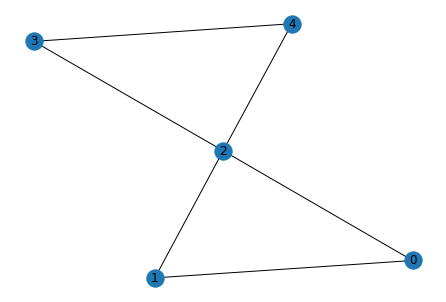

In [5]:
# create graph of coupling map
config=backend.configuration()
prop = backend.properties()
cm=config.coupling_map
G=nx.Graph(cm)
nx.draw(G, with_labels=True)

# find all paths of 5 qubits
npath = n_qubits
required_max_path_length = npath-1 # (inferior or equal to)

all_paths = []
nodes_combs = itertools.combinations(G.nodes, 2)
for source, target in nodes_combs:
    paths = nx.all_simple_paths(G, source=source, target=target, cutoff=required_max_path_length)
    for path in paths:
        if path not in all_paths and path[::-1] not in all_paths:
            if len(path)==npath:
                all_paths.append(path)

                # find the error rates corresponding to the paths
cx_errors = []
for p in all_paths:
    error = []
    for i in range(len(p)-1):
        error.append(prop.gate_error('cx', [p[i],p[i+1]]))
    cx_errors.append(error)
cx_errors = np.array(cx_errors)

# pick best qubits
cx_max_errors = np.max(cx_errors, axis=1)
best_qubits = all_paths[np.argmin(cx_max_errors)]

initial_layout=best_qubits
print('initial layout: ', initial_layout)

In [6]:
def build_circuits(initial_state):
    submit = [] # this list will store all circuits
    # measurement circuit of all but the last qubit
    # everything is measured in x-basis
    m = QuantumCircuit(n_qubits,n_qubits)
    for i in np.arange(n_qubits-1):
        m.h(i)

    m.measure(range(n_qubits-1),range(n_qubits-1))

    # tomography on the last qubit, i.e. measurement along x,y,z
    mz = QuantumCircuit(n_qubits,n_qubits)
    mz.measure(n_qubits-1,n_qubits-1)

    mx = QuantumCircuit(n_qubits,n_qubits)
    mx.h(n_qubits-1)
    mx.measure(n_qubits-1,n_qubits-1)

    my = QuantumCircuit(n_qubits,n_qubits)
    my.sdg(n_qubits-1)
    my.h(n_qubits-1)
    my.measure(n_qubits-1,n_qubits-1)

    # define the main circuit for different symmetry in [True,False]
    # and for all alphas

    for symmetry in sets:
        for alpha in alphas: 
            circuit = QuantumCircuit(n_qubits,n_qubits)

            # define initial state 
            #circuit.h(0)
            #circuit.sdg(0)
            #circuit.x(0)
            #circuit.h(0)
            if initial_state == 0:
                psi_in = np.array([1,0])
            elif initial_state == 1:
                circuit.x(0)
                psi_in = np.array([0,1])
            elif initial_state == 2:
                circuit.h(0)
                psi_in = np.array([1,1])/np.sqrt(2)
            elif initial_state == 3:
                circuit.x(0)
                circuit.h(0)
                psi_in = np.array([1,-1])/np.sqrt(2)
            elif initial_state == 4:
                circuit.h(0)
                circuit.s(0)
                psi_in = np.array([1,1j])/np.sqrt(2)
            elif initial_state == 5:
                circuit.h(0)
                circuit.sdg(0)
                psi_in = np.array([1,-1j])/np.sqrt(2)


            for i in np.arange(1,n_qubits):
                circuit.h(i)
            circuit.cz(0,1)
            circuit.cz(2,3)
            circuit.cz(1,2)
            circuit.cz(3,4)

            ###############################
            # unitary goes in here
            ###############################
            # 0 - symm preserving (long)
            # 1 - symm breaking (long)
            # 2 - id
            # 3 - symm breaking (short)
            many_qubit = ""
            single_qubit = "id"

            if symmetry == 0: # symmetry preserving single unitary
                circuit.rx(alpha, 3)
                single_qubit = r"$R_x(\alpha)_4$"
            if symmetry == 2: # symmetry preserving single unitary
                circuit.rx(-alpha, 3)
                single_qubit = r"$R_x(-\alpha)_4$"
            if symmetry == 1: # symmetry breaking single unitary
                circuit.ry(alpha, 3)
                single_qubit = r"$R_y(\alpha)_4$"
            if symmetry == 3: # symmetry breaking single unitary
                circuit.ry(-alpha, 3)
                single_qubit = r"$R_y(-\alpha)_4$"
            # symmetry preserving multi unitary
            circuit.cz(1,2)
            circuit.cz(2,3)
            circuit.rx(alpha, 2)
            circuit.cz(2,3)
            circuit.cz(1,2)
            many_qubit = r"$exp(i\alpha Z_2 X_3 Z_4)$"

            # description the symmetry preserving unitary, this string is printed as a plotlabel
            symstring[symmetry] = many_qubit + single_qubit
            ##############################
            ##############################
            submit.append(circuit+m+mx)
            submit.append(circuit+m+my)
            submit.append(circuit+m+mz)
    # print somce circuits to see if everything is implemented correctly
    # choose first 3 circuits of first half (symmetry preserving, alpha=0)
    # and choose first 3 circuits of second half (symmetry brealing, alpha=0)
    #print_selected = np.array([3])
    #drawcircuits(submit, print_selected)
    return submit, psi_in

In [7]:
def transpile_circuits(submit):
    submit_t = transpile(submit, backend=backend,optimization_level=olevel, initial_layout=initial_layout)

    # print to check the transpiled circuit
    # for alpha = alphas[0]
    print_figs = [4]#[0,1,2,3,4,5]#len(submit_t)//2,len(submit_t)//2+1,len(submit_t)//2+2]
    for i in print_figs:
        f1 = plt.figure(); ax = f1.add_subplot(111);
        submit_t[i].draw(idle_wires=False, output='mpl',scale=0.5, ax=ax)
    return submit_t

In [8]:
def run_jobs(submit_t, namestring):
    qr = qiskit.QuantumRegister(backend.configuration().n_qubits)
    meas_calibs, state_labels = complete_meas_cal(qubit_list=initial_layout, qr=qr, circlabel='mcal')
    job_calib = qiskit.execute(meas_calibs, backend=sim_backend, shots=8192)

    # I use the jobmanager to submit all jobs necessary to create one figure at once. this will automatically split up
    # submit_t, that contains all transpiled circuits, into jobs of 75 circuits each. The maximum number of allowed jobs 
    # in the queue is 5, which amounts to 5*75=375 circuit. Once should make sure that n_sets*len(alphas)*3 is less than 375
    job_manager = IBMQJobManager()
    job_exp = job_manager.run(submit_t, backend=sim_backend, name=namestring, shots=nshots, max_experiments_per_job=75*4*4,optimization_level=olevel)
    """
    # Generate a noise model for the 5 qubits
    noise_model = noise.NoiseModel()
    for qi in initial_layout:
        read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
        noise_model.add_readout_error(read_err, [qi])

    job_exp = qiskit.execute(submit_t, Aer.get_backend('qasm_simulator'), shots=nshots, noise_model=noise_model)
    result = job_exp.result()
    #""";
    return job_calib, state_labels, job_exp

In [9]:
def analyze(initial_state, result, psi_in, namestring, replace_last):
    f = np.zeros((2,n_sets,len(alphas)), dtype=complex)
    p = np.zeros((2,n_sets,len(alphas)), dtype=complex)

    plt.figure(figsize=(10,5))
    mm = 0
    for mitigate in [True,False]:
        plt.subplot(1,2,int(mitigate)+1)
        for j in np.arange(n_sets):
            for a in np.arange(len(alphas)):            
                # arrays store measurements of |0> and |1> for all three axes
                up = np.zeros(3)
                down = np.zeros(3)
                for axis in np.arange(3):
                    r_raw = result.get_counts(int(j*3*len(alphas) + 3*a + axis))
                    if mitigate:
                        r = meas_filter.apply(r_raw)
                    else:
                        r = r_raw
                    for i in np.arange((n_qubits-1)**2):
                        # the first (n_qubits-1) qubits are all measured in x basis
                        # the pauli corrections will be different depending on the measurement outcomes
                        # we therefor loop through all of the (n_qubits-1)**2 different outcomes

                        # convert i to binary and extracted results s1, s2, ... 
                        binary = get_bin(i)
                        s1 = int(binary[-1])
                        s2 = int(binary[-2])
                        s3 = int(binary[-3])
                        s4 = int(binary[-4])

                        if axis == 0:
                            factor = (-1)**(s1+s3)
                        elif axis == 1:
                            factor = (-1)**(s1+s2+s3+s4)
                        else:
                            factor = (-1)**(s2+s4)

                        if factor == 1: 
                            up[axis] += ret(r,'0'+binary)
                            down[axis] += ret(r,'1'+binary)
                        else: 
                            down[axis] += ret(r,'0'+binary)
                            up[axis] += ret(r,'1'+binary)
                # perform quantum state tomography on the last qubit
                rho_exp = 0.5 * np.array(s0, dtype= complex)
                for axis in np.arange(3):
                    rho_exp += 0.5 * (up[axis]-down[axis])/(up[axis]+down[axis]) * s[axis]
                #f[mm,j,a] = state_fidelity(psi_in, rho_exp)
                f[mm,j,a] = psi_in.T.conj() @ rho_exp @ psi_in
                p[mm,j,a] = np.trace(rho_exp@rho_exp)
            plt.plot(alphas, f[mm,j].real, '.-', label=symstring[j])
        plt.title(namestring + f"\n layout " + str(initial_layout) + f"\n{job_exp.jobs()[0].job_id()}")
        plt.xlabel(r"$\alpha$")
        plt.ylabel("Fidelity")
        if mitigate:
            f_min = np.min(np.min(f[mm].real))*0.85
            f_max = np.max(np.max(f[mm].real))*1.1
        plt.ylim((0, min(f_max, 1)))
        plt.legend()
        plt.tight_layout()
        mm += 1


    # save all figures to new file (or replace last file if replace_last=True)
    # the job_id in the plot title allows us to retrieve the data from the IBM server to replot the figure in high quality
    num = "_" + str(initial_state)
    plt.savefig(next_file("sim"+num+f"_{qc}", file_extension="jpg", replace_last=replace_last))
    submit[0].draw(output='mpl', filename=next_file("a_sim"+num,file_extension="png", replace_last=replace_last))
    submit[len(submit)//2].draw(output='mpl', filename=next_file("b_sim"+num,file_extension="png", replace_last=replace_last))
    submit_t[0].draw(output='mpl', idle_wires=False, filename=next_file("a_transpiled"+num,file_extension="png", replace_last=replace_last))
    submit_t[len(submit_t)//2].draw(output='mpl', idle_wires=False, filename=next_file("b_transpiled"+num,file_extension="png", replace_last=replace_last))
    replace_last = True
    
    return alphas, f, p


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

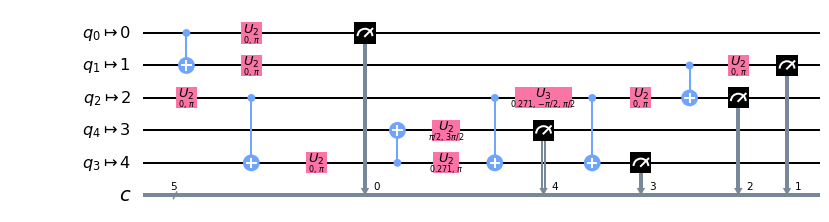

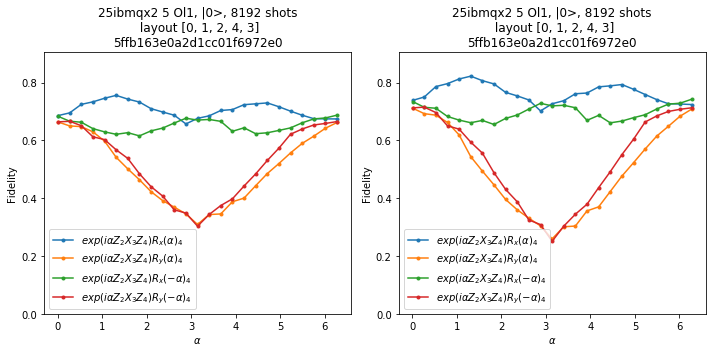

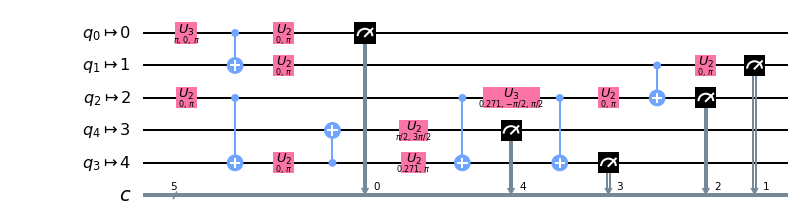

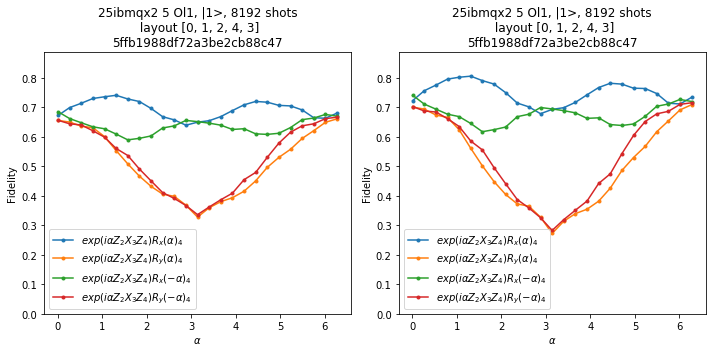

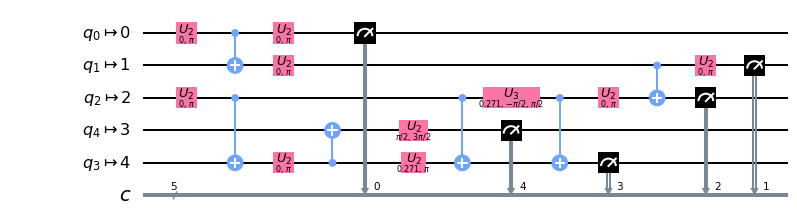

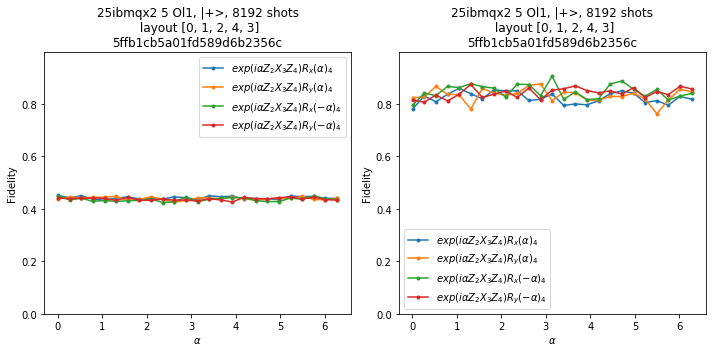

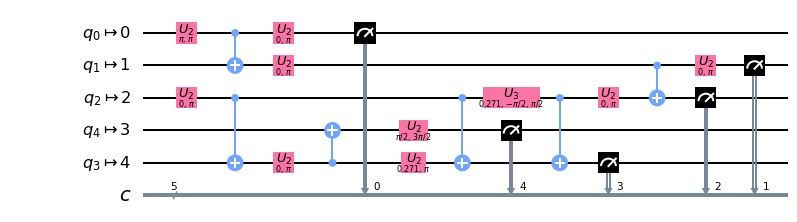

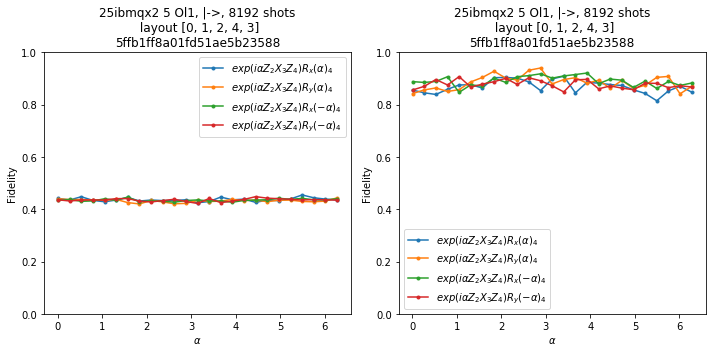

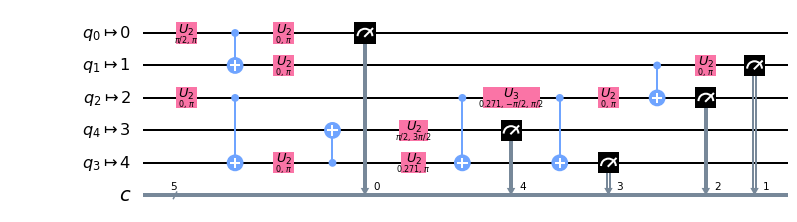

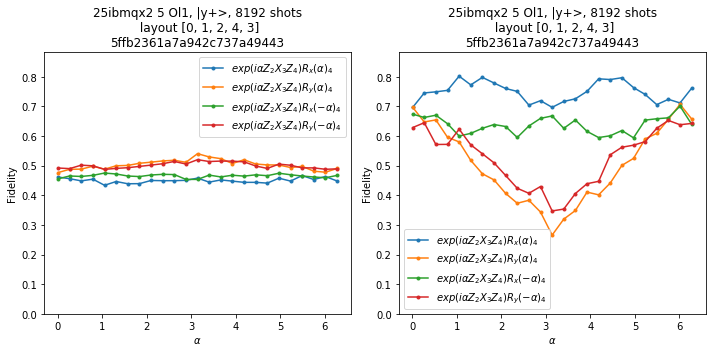

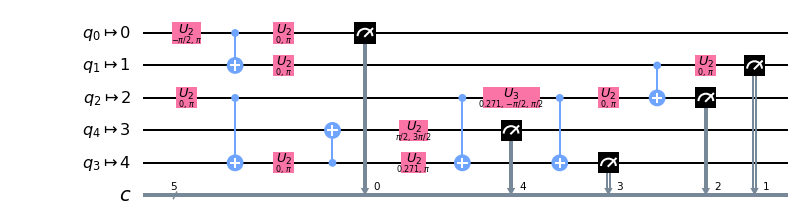

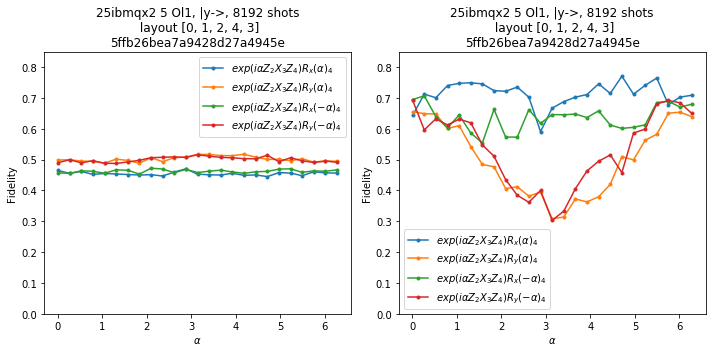

In [10]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)
fn_pickle=next_file(f"data-{qc}",file_extension="pickle", replace_last=False)

for initial_state in np.arange(len(state)):
    submit, psi_in = build_circuits(initial_state)
    namestring = str(len(alphas)) + qc + " " + str(n_qubits) + f" Ol{olevel}, {state[initial_state]}, {nshots} shots"
    submit_t = transpile_circuits(submit)
    job_calib, state_labels, job_exp = run_jobs(submit_t, namestring)



    job_monitor(job_calib)
    for j in np.arange(len(job_exp.jobs())):
        job_monitor(job_exp.jobs()[j])

    result = job_exp.results()
    counts = []
    for k in range(len(submit)):
        r = result.get_counts(k)
        counts.append(r)
    cal_results = job_calib.result()
    replace_last = False 

    # measurement error mitigation
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=initial_layout, circlabel='mcal')
    #plt.imshow(meas_fitter.cal_matrix,vmin=0,vmax=1)
    #plt.colorbar()
    #print(np.diag(meas_fitter.cal_matrix))
    meas_filter = meas_fitter.filter

    aa, ff, pp = analyze(initial_state, result, psi_in, namestring, replace_last=replace_last)



    data={"job_result":job_exp.jobs()[0].job_id(),
          "timestamp": datetime.datetime.now(),
          "alphas":aa,
          "fidelity":ff,
          "purity":pp,
          "counts": counts,
          "qc":qc,
          "initial_state":initial_state,
          "initial_layout":initial_layout,
          "n_qubits":n_qubits,
          "olevel":olevel,
          "nshots":nshots,
          "cal_matrix":meas_fitter.cal_matrix,
          "sets":sets,
          "states":state,
          "symstring":symstring,
          "backend_properties": prop
          #  "result":result,
        #  "cal_result":cal_results,
         # "state_labels":state_labels
         }
    pickle.dump(data, open(fn_pickle , "ab" ) )

In [11]:
loadfile = f'0_data-{qc}'
infile = open(f'exp-data/{loadfile}.pickle','rb')
datasets = []
for i in np.arange(len(state)):
    datasets.append(pickle.load(infile))
infile.close()

Text(0, 0.5, 'Minimum fidelity $f_{min}$')

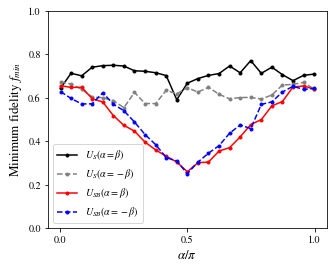

In [12]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

mit = 0
plt.rcParams["figure.figsize"] = (5, 4)
fff = datasets[0]["fidelity"][mit].real
for initial_s in np.arange(1,6):
    for jj in np.arange(4):
        fff[jj] = np.minimum(fff[jj], datasets[initial_s]["fidelity"][mit,jj].real)
fig, ax = plt.subplots()
style = ['.-','.-','.--','.--']
colors = ['black', 'red', 'gray', 'blue']
legend = [r'$U_S(\alpha=\beta)$',r'$U_{SB}(\alpha=\beta)$',r'$U_S(\alpha=-\beta)$',r'$U_{SB}(\alpha=-\beta)$']
order = [0,2,1,3]
for kk in order:
    ax.plot(datasets[0]["alphas"]/np.pi/2,fff[kk],style[kk],label=legend[kk], color=colors[kk])
plt.ylim((0,1))
plt.legend()
ax.set_xticks([0, 0.5, 1])


FONTSIZE = 13
plt.xlabel(r"$\alpha/\pi$",fontsize=FONTSIZE)
plt.ylabel(r"Minimum fidelity $f_{min}$",fontsize=FONTSIZE)
#plt.savefig('figures5_santiago/old_5_sim_min_mit.pdf')

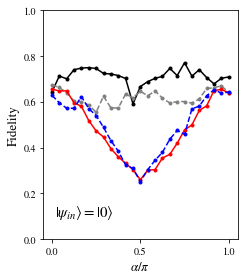

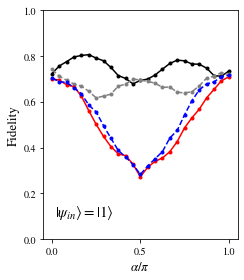

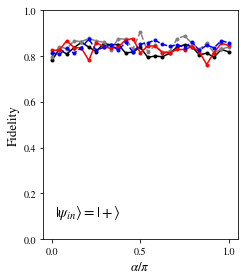

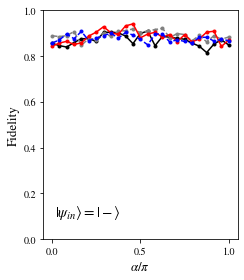

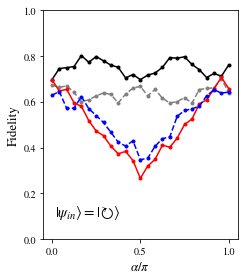

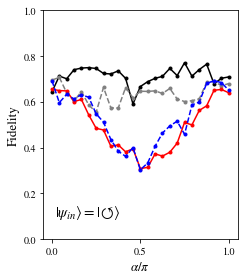

In [13]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
state = ['0','1','+','-',r'\circlearrowright',r'\circlearrowleft']

#plt.rc('text.latex', preamble=r'\usepackage{braket}')
params = {'text.latex.preamble' : [r'\usepackage{braket}', r'\usepackage{amsmath}']}
matplotlib.rcParams.update(params)
#matplotlib.verbose.level = 'debug-annoying'

mit = 0
plt.rcParams["figure.figsize"] = (3.5, 4)
fff = datasets[0]["fidelity"][mit].real
for initial_s in np.arange(6):
    for jj in np.arange(4):
        fff[jj] = datasets[initial_s]["fidelity"][mit,jj].real
    fig, ax = plt.subplots()
    style = ['.-','.-','.--','.--']
    colors = ['black', 'red', 'gray', 'blue']
    legend = [r'$U_S(\alpha=\beta)$',r'$U_{SB}(\alpha=\beta)$',r'$U_S(\alpha=-\beta)$',r'$U_{SB}(\alpha=-\beta)$']
    order = [0,2,1,3]
    for kk in order:
        ax.plot(datasets[0]["alphas"]/np.pi/2,fff[kk],style[kk],label=legend[kk], color=colors[kk])
    plt.ylim((0,1))
    #plt.legend()
    ax.set_xticks([0, 0.5, 1])


    FONTSIZE = 13
    plt.xlabel(r"$\alpha/\pi$",fontsize=FONTSIZE)
    plt.ylabel("Fidelity",fontsize=FONTSIZE)
    plt.text(0.02,0.1,r'$\left\|\psi_{in}\right> = |'+state[initial_s]+r'\rangle$',fontsize=15)
    plt.tight_layout()
    #plt.savefig(f'figures5_santiago/old_5_sim_apdx_{initial_s}_mit.pdf')